### Summary of the Notebook

This notebook provides a comprehensive set of tools for image preprocessing and visualization.

### Imports

In [1]:
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np

### Read image

In [2]:
# A function to read images using cv2
def read_image(image_path):
	"""
	Read an image from the given path using cv2.
	
	Parameters:
		image_path (str): The path to the image file.
		
	Returns:
		numpy.ndarray: The image read by cv2 in BGR format.
	"""
	return cv2.imread(image_path)

### Display image

In [3]:
# A function to display an image using cv2
def display_image_cv2(image):
	"""
	Display the given image using cv2 in Jupyter Notebook.
	
	Parameters:
		image (numpy.ndarray): The input image to be displayed.
	"""
	# Convert BGR to RGB for displaying correctly
	rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(rgb_image)
	plt.axis('off')  # Hide axes for better visualization
	plt.show()

In [4]:
# A function to dynamically show several images based on the input
# For example: display_images(my_img) will show just one image
#   display_images(my_img, second_img) will show the two images in a grid, and so on
def display_images(*images, titles=None, figsize=(15, 10)):
	"""
	Display multiple images in a grid layout.

	Parameters:
		images (list of PIL.Image or numpy.ndarray): The images to display.
		titles (list of str, optional): Titles for each image. Defaults to None.
		figsize (tuple, optional): Size of the figure. Defaults to (15, 10).
	"""
	num_images = len(images)
	cols = int(np.ceil(np.sqrt(num_images)))
	rows = int(np.ceil(num_images / cols))
	
	fig, axes = plt.subplots(rows, cols, figsize=figsize)
	axes = axes.flatten() if num_images > 1 else [axes]
	
	for i, ax in enumerate(axes):
		if i < num_images:
			img = images[i]
			if isinstance(img, np.ndarray):  # If the image is a numpy array
				img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
				ax.imshow(img)
			elif isinstance(img, Image.Image):  # If the image is a PIL image
				ax.imshow(img)
			else:
				raise ValueError("Unsupported image type")
			
			if titles and i < len(titles):
				ax.set_title(titles[i], fontsize=12)
		ax.axis('off')
	
	plt.tight_layout()
	plt.show()


### Equalize light

In [5]:
def equalize_light(image, limit=3, grid=(7,7), gray=False):
    if (len(image.shape) == 2):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        gray = True
    
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))

    image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    if gray: 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return np.uint8(image)

### Gauss filter

In [6]:
def gauss_filter(image, kernel=(3,3), iterations=1):
    for _ in range(iterations):
        image = cv2.GaussianBlur(image, kernel, 0)
    return np.uint8(image)

### Light adjustment

In [7]:
def light(image, bright, contrast):
    bright = bright * 1.2
    contrast = contrast * 2
    image = image * ((contrast/127)+1) - contrast + bright
    image = np.clip(image, 0, 255)
    return np.uint8(image)

### Binarization

In [8]:
# A function to binarize an image
def binarize(image, threshold=127):
    """
    Binarize an image using a given threshold.

    Parameters:
        image (numpy.ndarray): The input image to be binarized.
        threshold (int): The threshold value for binarization. Default is 127.

    Returns:
        numpy.ndarray: The binarized image.
    """
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def binarize_otsu(image):
    """
    Binarize an image using Otsu's thresholding method.
    Parameters:
        image (numpy.ndarray): The input image to be binarized.
    Returns:
        numpy.ndarray: The binarized image.
    """ 
    # If image is already grayscale, don't convert
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

In [20]:

def otsu(img):
    hist = np.zeros(256, dtype=int)

    for y in range(len(img)):
        for x in range(len(img[0])):
            hist[int(img[y,x])] += 1

    total = (len(img) * len(img[0]))

    current_max, threshold = 0, 0
    sumT, sumF, sumB = 0, 0, 0

    weightB, weightF = 0, 0
    varBetween, meanB, meanF = 0, 0, 0

    for i in range(0,256):
        sumT += (i * hist[i])

    for i in range(0,256):
        weightB += hist[i]
        weightF = total - weightB
        if (weightF <= 0):
            break
        if (weightB <= 0):
            weightB = 1

        sumB += (i * hist[i])
        sumF = sumT - sumB
        meanB = sumB/weightB
        meanF = sumF/weightF
        varBetween = (weightB * weightF)
        varBetween *= (meanB-meanF) * (meanB-meanF)

        if (varBetween > current_max):
            current_max = varBetween
            threshold = i

    img[img <= threshold] = 0
    img[img > threshold] = 255
    return np.array(img, dtype=np.uint8)

In [111]:
def subtract_background(image, erode_kernel=(5,5), dilate_kernel=(15,15), erode_iter=1, dilate_iter=2):
    """
    Subtracts the background from an image using morphological operations,
    allowing for different kernel sizes and iteration counts for erosion and dilation.

    Parameters:
        image (numpy.ndarray): Input image (grayscale or binary).
        erode_kernel (tuple): Size of the structuring element for erosion.
        dilate_kernel (tuple): Size of the structuring element for dilation.
        erode_iter (int): Number of times erosion is applied.
        dilate_iter (int): Number of times dilation is applied.

    Returns:
        numpy.ndarray: Image with background subtracted.
    """
    erode_k = np.ones(erode_kernel, np.uint8)
    dilate_k = np.ones(dilate_kernel, np.uint8)
    #mask = cv2.erode(image, erode_k, iterations=erode_iter)
    #mask = cv2.dilate(mask, dilate_k, iterations=dilate_iter)
    mask = cv2.dilate(image, dilate_k, iterations=erode_iter)
    mask = cv2.erode(mask, erode_k, iterations=erode_iter)
    result = np.subtract(image, mask)
    return result

In [24]:
def invert_if_not_black_and_white(image):
    """
    Invert the image if it is not already black and white (binary).

    Parameters:
        image (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: Possibly inverted image.
    """
    # Check if image is binary (only 0 and 255 values)
    unique_vals = np.unique(image)
    if not (np.array_equal(unique_vals, [0, 255]) or np.array_equal(unique_vals, [0]) or np.array_equal(unique_vals, [255])):
        return cv2.bitwise_not(image)
    return image

In [26]:
def invert_black_and_white(image):
    """
    Invert a black-and-white (binary) image: 0 becomes 255, 255 becomes 0.

    Parameters:
        image (numpy.ndarray): Input binary image.

    Returns:
        numpy.ndarray: Inverted binary image.
    """
    return 255 - image

## Main code

In [11]:
images = os.listdir("img")
img_path = os.path.join("img", images[10])
print(img_path)

img/IMG_0999_tile_8.png


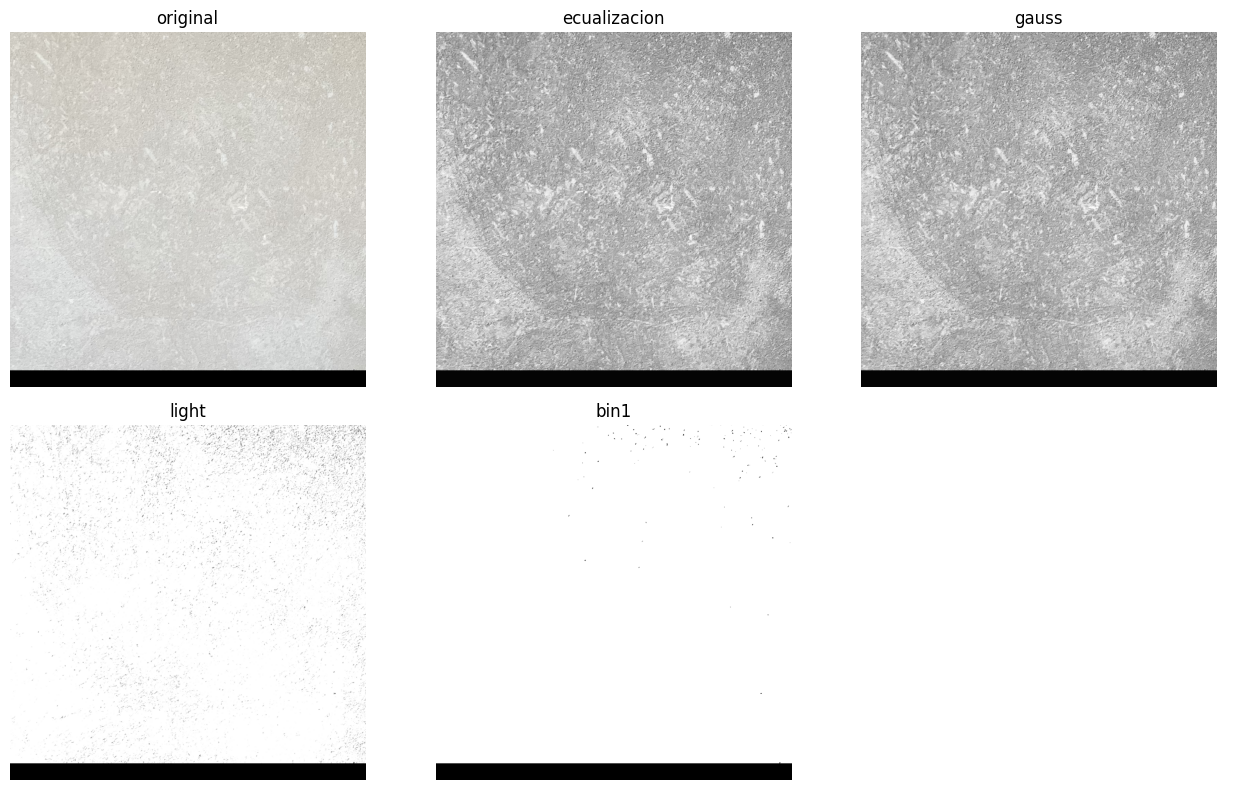

In [12]:
cv_img = read_image(img_path)
img_bin = equalize_light(cv_img, limit=2, grid=(2,2), gray=True)
img_gauss = gauss_filter(img_bin, kernel=(1, 1))
img_light = light(img_gauss, 50, 150)
img_bin1 = binarize(img_light, 127) #127
display_images(cv_img, img_bin, img_gauss, img_light, img_bin1,
               titles=('original', 'ecualizacion', 'gauss', 'light', 'bin1'),
               figsize=(13, 8))

In [13]:
# Define the processing pipeline as a function
def process_image(
    image,
    equalize_params={'limit': 2, 'grid': (2, 2), 'gray': True},
    gauss_params={'kernel': (1, 1), 'iterations': 1},
    light_params={'bright': 50, 'contrast': 150},
    binarize_params={'threshold': 127}
):
    img_bin = equalize_light(image, **equalize_params)
    img_gauss = gauss_filter(img_bin, **gauss_params)
    img_light = light(img_gauss, **light_params)
    img_bin1 = binarize(img_light, **binarize_params)
    return img_bin1

In [14]:
def batch_process_images(
    input_dir,
    output_dir,
    equalize_params={'limit': 2, 'grid': (2, 2), 'gray': True},
    gauss_params={'kernel': (1, 1), 'iterations': 1},
    light_params={'bright': 50, 'contrast': 150},
    binarize_params={'threshold': 127},
    file_exts={'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for fname in os.listdir(input_dir):
        if not any(fname.lower().endswith(ext) for ext in file_exts):
            continue
        img_path = os.path.join(input_dir, fname)
        img = read_image(img_path)
        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue
        result = process_image(
            img,
            equalize_params=equalize_params,
            gauss_params=gauss_params,
            light_params=light_params,
            binarize_params=binarize_params
        )
        out_path = os.path.join(output_dir, fname)
        cv2.imwrite(out_path, result)
        print(f"Processed and saved: {out_path}")


In [15]:

batch_process_images(
    input_dir='img',
    output_dir='img_processed',
    equalize_params={'limit': 2, 'grid': (2, 2), 'gray': True},
    gauss_params={'kernel': (1, 1), 'iterations': 1},
    light_params={'bright': 50, 'contrast': 150},
    binarize_params={'threshold': 127}
)

Processed and saved: img_processed/IMG_0999_tile_2.png
Processed and saved: img_processed/IMG_0999_tile_7.png
Processed and saved: img_processed/IMG_0999_tile_9.png
Processed and saved: img_processed/IMG_0999_tile_5.png
Processed and saved: img_processed/IMG_0999_tile_10.png
Processed and saved: img_processed/IMG_0999.png
Processed and saved: img_processed/IMG_0999_tile_1.png
Processed and saved: img_processed/IMG_0999_tile_11.png
Processed and saved: img_processed/IMG_0999_tile_3.png
Processed and saved: img_processed/IMG_0999_tile_4.png
Processed and saved: img_processed/IMG_0999_tile_8.png
Processed and saved: img_processed/IMG_0999_tile_0.png
Processed and saved: img_processed/IMG_0999_tile_6.png
